# Purpose of Collab
This collab is used to search for the best hyperparameters in order to train and get the best possible model. The Convolutional Neural Networks architecture will be the base of this collab as we are dealing with the Cifar-10 dataset which consists of colour images.

In the search of the best hyperparameters, different learning rates, number of layers, parameters per layer, activation functions etc are tested. At the same time, different Keras Implementations for hyperparameter tuning are exploited such as Grid Search, Random Search and Bayesian Optimization.

In [ ]:
import numpy as np
from sklearn.metrics import *
from matplotlib import pyplot as plt
import math
from keras.datasets import cifar10
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
!pip install keras-tuner --upgrade
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras_tuner.tuners import RandomSearch,BayesianOptimization,GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.optimizers import Adam,SGD
!pip install visualkeras
import visualkeras
from sklearn.model_selection import train_test_split
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
# Downloading the dataset (CIFAR-10) using keras datasets
def load_dataset():
 # load dataset
 (X_train,y_train),(X_test,y_test) = cifar10.load_data()
 return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = load_dataset()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
# We know that the pixels in each image is between no colour and full color and thus [0,255]
# We also know that normalization can help neural networks
def normalization_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

X_train, X_test = normalization_pixels(X_train,X_test)

In [ ]:
# Initial Exploration of the dataset and its dimensions
X_train,y_train,X_test,y_test =  load_dataset()
print("The shape of X_train is :",X_train.shape)
print("The shape of y_train is :",y_train.shape)

print("The shape of X_test is :",X_test.shape)
print("The shape of y_test is :",y_test.shape)

print("The number of unique classes is:",len(np.unique(y_train)))

labels =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Class Names are:",labels)

The shape of X_train is : (50000, 32, 32, 3)
The shape of y_train is : (50000, 1)
The shape of X_test is : (10000, 32, 32, 3)
The shape of y_test is : (10000, 1)
The number of unique classes is: 10
Class Names are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Function to calculate and print different classification metrics for comparison of our models
def evaluate_classification_metrics(y_true, y_pred,verbose=True):


    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, and F1-score for all unique labels
    precision = precision_score(y_true, y_pred,zero_division=0, average='weighted')
    recall = recall_score(y_true, y_pred,zero_division=0, average='weighted')
    f1 = f1_score(y_true, y_pred,zero_division=0,average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Generate a classification report
    class_report = classification_report(y_true, y_pred, zero_division=0)
    if verbose:
      print(f'\tAccuracy: {accuracy}')
      print(f'\tPrecision Weighted: {precision}')
      print(f'\tRecall Weighted: {recall}')
      print(f'\tF1-Score Weighted: {f1}')

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

In [ ]:
# Preprocess target labels for our neural networks by performing one hot encoding
def preprocess_labels(y_train,y_test,number_of_classes):
  # one hot encode target values
  y_train = keras.utils.to_categorical(y_train,num_classes=number_of_classes)
  y_test = keras.utils.to_categorical(y_test,num_classes=number_of_classes)
  return y_train,y_test

y_train,y_test = preprocess_labels(y_train,y_test,len(labels))
print("Shape of one-hot-encoded y_train: ",y_train.shape)

Shape of one-hot-encoded y_train:  (50000, 10)


Before start to searching for the optimal model, a validation set is extracted in order for the test set not to be used during training.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
def model_plots(history,model_name):

  # Set a larger width for the plots
  figsize = (15, 6)

  # Create the figure with the specified figsize
  plt.figure(figsize=figsize)

  # Plotting loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(model_name + '  Learning Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plotting accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(model_name + ' Accuracy Learning Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Function to visualize intermediate outputs of the Convolutional Layers
# Each filter in a layer is responsible for detecting specific patterns and thus
# extracting specific features
def visualize_intermediate_outputs(model, layer_names, input_data):
    intermediate_layer_models = [Model(inputs=model.input, outputs=model.get_layer(layer_name).output) for layer_name in layer_names]

    intermediate_outputs = [intermediate_model.predict(input_data) for intermediate_model in intermediate_layer_models]

    # Original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(layer_names) + 1, 1)
    plt.imshow(input_data[0])
    plt.axis('off')
    plt.title('Original Image')
    # Display up to 8 feature maps (if more are displayed, the figures then will lack quality)
    for i, layer_name in enumerate(layer_names):
        plt.figure(figsize=(15, 5))
        for j in range(min(8, intermediate_outputs[i].shape[-1])):
            plt.subplot(1, 8, j + 1)
            plt.imshow(intermediate_outputs[i][0, :, :, j], cmap='viridis')
            plt.axis('off')
            plt.title(f'{layer_name}_filter_{j+1}')
        plt.show()

In this section, some hyper-parameter tuning methods are followed in order to built a Neural Network with Convolutional and Dense layers (and other layers between of course) to maximize the predictive power on Cifar-10.

A fundamental layer that is used in this new exploration of Neural Networks is Conv2D layer.  The Conv2D layer is exploited in order to perform spatial convolution over the dataset images (in contrast with the Conv1D which would be used if time-series data were the base of the problem). The common hyperparameters of the Conv2D layers are the number of filters/kernels and the dimension of the kernels.

The number of filters represents the number of filters applied in the convolutional layer. Each filter is responsible for detecting specific features or patterns in the input data. The number of filters determines how many different features the layer can learn. In the context of an image, each filter can be thought of as looking for a specific pattern or feature, such as edges, textures, or more complex structures.

Common choices include 32 or 64 filters, and kernel sizes like (3, 3) or (5, 5) according to various articles.

Other layers will be exploited as well such as MaxPooling2D layers that help use downsample the spatial features (reduce dimensions) and of course the Flatten layer used to flatten the output before performing the predictions. The Flatten layer has similar functionalities to the numpy function that has the same name and has been used in the other collabs to flatten the input images.


Epoch 1/5
1250/1250 [==============================] - 21s 11ms/step - loss: 3.5148 - accuracy: 0.1097 - val_loss: 2.2824 - val_accuracy: 0.1255
Epoch 2/5
1250/1250 [==============================] - 9s 7ms/step - loss: 2.2348 - accuracy: 0.1676 - val_loss: 2.2019 - val_accuracy: 0.2002
Epoch 3/5
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1824 - accuracy: 0.2030 - val_loss: 2.1964 - val_accuracy: 0.2014
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1050 - accuracy: 0.2487 - val_loss: 2.2123 - val_accuracy: 0.1813
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0557 - accuracy: 0.2690 - val_loss: 2.2491 - val_accuracy: 0.2143
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 

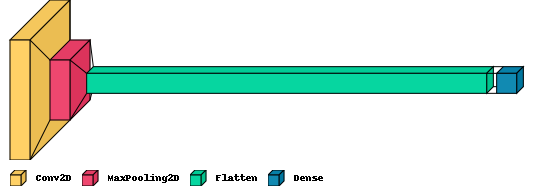

In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print(model.summary())
print('Training Time:', end_time - start_time)
visualkeras.layered_view(model,legend=True)

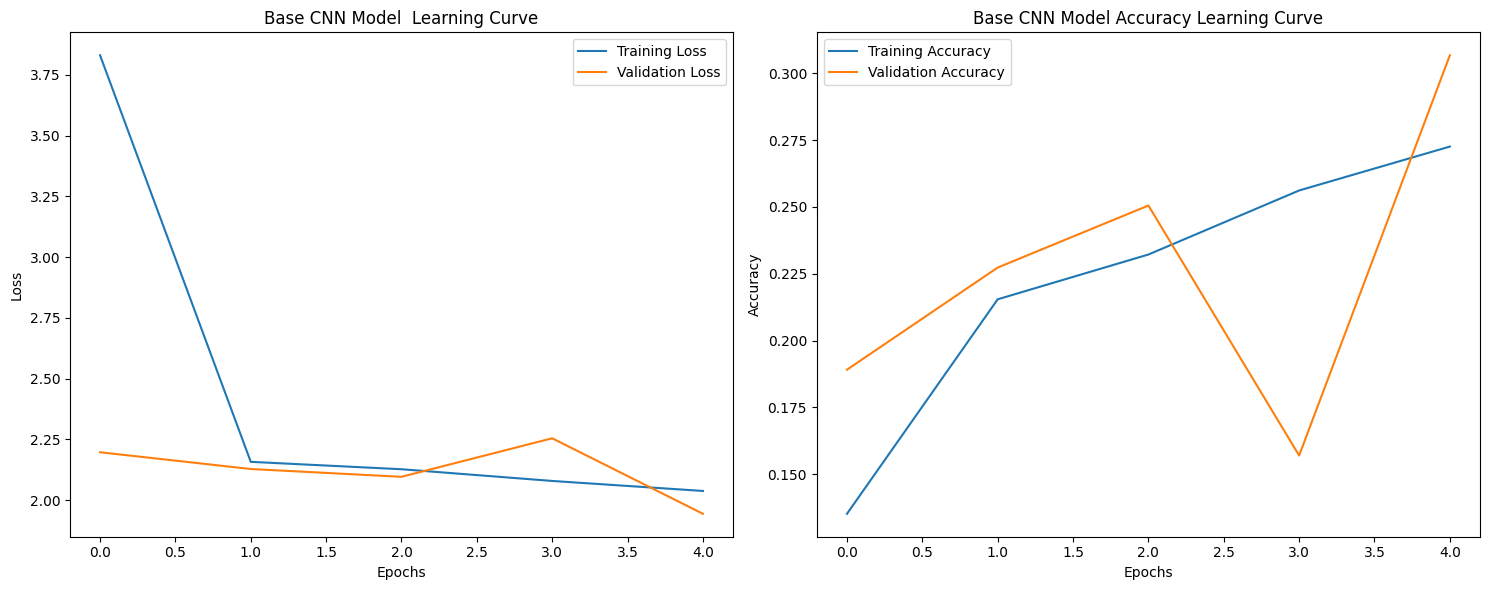

In [ ]:
model_plots(history,'Base CNN Model')

In [ ]:
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Extra Metrics on Validation Set:
	Accuracy: 0.2097
	Precision Weighted: 0.285732624083572
	Recall Weighted: 0.2097
	F1-Score Weighted: 0.18741849038424727


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((4, 4)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 10s 7ms/step - loss: 2.6788 - accuracy: 0.1104 - val_loss: 2.2983 - val_accuracy: 0.1182
Epoch 2/5
1250/1250 [==============================] - 7s 6ms/step - loss: 2.2887 - accuracy: 0.1276 - val_loss: 2.2689 - val_accuracy: 0.1488
Epoch 3/5
1250/1250 [==============================] - 7s 5ms/step - loss: 2.2382 - accuracy: 0.1637 - val_loss: 2.1679 - val_accuracy: 0.2102
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 2.1667 - accuracy: 0.2124 - val_loss: 2.1614 - val_accuracy: 0.2203
Epoch 5/5
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1199 - accuracy: 0.2412 - val_loss: 2.2928 - val_accuracy: 0.1196
Training Time: 43.37388563156128
Extra Metrics on Validation Set:
	Accuracy: 0.1145
	Precision Weighted: 0.15223398263601165
	Recall Weighted: 0.1145
	F1-Score Weighted: 0.0569838401723287


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 7s 5ms/step - loss: 2.6661 - accuracy: 0.2334 - val_loss: 1.9667 - val_accuracy: 0.3046
Epoch 2/5
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0163 - accuracy: 0.2932 - val_loss: 1.9706 - val_accuracy: 0.3117
Epoch 3/5
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0225 - accuracy: 0.2895 - val_loss: 2.2022 - val_accuracy: 0.2051
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0314 - accuracy: 0.2837 - val_loss: 1.9750 - val_accuracy: 0.3095
Epoch 5/5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9146 - accuracy: 0.3281 - val_loss: 2.0722 - val_accuracy: 0.2551
Training Time: 42.02978539466858
Extra Metrics on Validation Set:
	Accuracy: 0.2527
	Precision Weighted: 0.27015253351503377
	Recall Weighted: 0.2527
	F1-Score Weighted: 0.2343222358767007


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 6s 5ms/step - loss: 4.1213 - accuracy: 0.2499 - val_loss: 1.9261 - val_accuracy: 0.3234
Epoch 2/5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9004 - accuracy: 0.3357 - val_loss: 1.7734 - val_accuracy: 0.3935
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7925 - accuracy: 0.3822 - val_loss: 1.8497 - val_accuracy: 0.3522
Epoch 4/5
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8222 - accuracy: 0.3704 - val_loss: 1.8682 - val_accuracy: 0.3531
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8778 - accuracy: 0.3499 - val_loss: 1.9527 - val_accuracy: 0.3214
Training Time: 41.89181399345398
Extra Metrics on Validation Set:
	Accuracy: 0.3175
	Precision Weighted: 0.3208737222279916
	Recall Weighted: 0.3175
	F1-Score Weighted: 0.3122751781310912


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='sigmoid', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9251 - accuracy: 0.3033 - val_loss: 1.7376 - val_accuracy: 0.3756
Epoch 2/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6773 - accuracy: 0.4007 - val_loss: 1.6300 - val_accuracy: 0.4142
Epoch 3/5
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5826 - accuracy: 0.4392 - val_loss: 1.5280 - val_accuracy: 0.4601
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5200 - accuracy: 0.4626 - val_loss: 1.4966 - val_accuracy: 0.4750
Epoch 5/5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4741 - accuracy: 0.4804 - val_loss: 1.4536 - val_accuracy: 0.4863
Training Time: 39.384830474853516
Extra Metrics on Validation Set:
	Accuracy: 0.4814
	Precision Weighted: 0.4895195814098404
	Recall Weighted: 0.4814
	F1-Score Weighted: 0.47265048636257734


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9314 - accuracy: 0.1302 - val_loss: 2.2521 - val_accuracy: 0.1638
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2141 - accuracy: 0.1866 - val_loss: 2.1615 - val_accuracy: 0.2169
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1436 - accuracy: 0.2265 - val_loss: 2.1118 - val_accuracy: 0.2594
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2124 - accuracy: 0.1797 - val_loss: 2.1011 - val_accuracy: 0.2517
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0885 - accuracy: 0.2529 - val_loss: 2.0559 - val_accuracy: 0.2733
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1153 - accuracy: 0.2386 - val_loss: 2.1560 - val_accuracy: 0.2159
Epoch 7/10
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0273 - accuracy: 0.2805 - val_loss: 1.9891 - val_accuracy

In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = Adam(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.8538 - accuracy: 0.2655 - val_loss: 1.9065 - val_accuracy: 0.3469
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8035 - accuracy: 0.3823 - val_loss: 1.8798 - val_accuracy: 0.3723
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6721 - accuracy: 0.4238 - val_loss: 1.8666 - val_accuracy: 0.3654
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6004 - accuracy: 0.4472 - val_loss: 1.9086 - val_accuracy: 0.3664
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5761 - accuracy: 0.4570 - val_loss: 1.8858 - val_accuracy: 0.3904
Training Time: 25.25597643852234
Extra Metrics on Validation Set:
	Accuracy: 0.3742
	Precision Weighted: 0.3935742208169866
	Recall Weighted: 0.3742
	F1-Score Weighted: 0.37519727287700244


In [ ]:
import time
# Create a Base Model - the simplier model using a Convolution layer
opt = SGD(learning_rate=0.001) # Stochastic Gradient Descent optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                    Flatten(),
                    Dense(10, activation='softmax')])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time =  time.time()
print('Training Time:', end_time - start_time)
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/5
1250/1250 [==============================] - 5s 4ms/step - loss: 3.6731 - accuracy: 0.1854 - val_loss: 2.1240 - val_accuracy: 0.2341
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0688 - accuracy: 0.2592 - val_loss: 2.0129 - val_accuracy: 0.3094
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9417 - accuracy: 0.3183 - val_loss: 1.9413 - val_accuracy: 0.3205
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8853 - accuracy: 0.3387 - val_loss: 1.9276 - val_accuracy: 0.3303
Epoch 5/5
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9023 - accuracy: 0.3386 - val_loss: 2.1123 - val_accuracy: 0.2667
Training Time: 25.433655261993408
Extra Metrics on Validation Set:
	Accuracy: 0.2589
	Precision Weighted: 0.26421639888130416
	Recall Weighted: 0.2589
	F1-Score Weighted: 0.24915227560541156


The learning curves do not have the "normal" monotonous shape that usually shows that the model learns. At the other hand, the curves showcase zik-zaks and ups and downs.
Trying the simplest model with the more complex Adam Optimizer as well.

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 10.2681 - accuracy: 0.3055 - val_loss: 5.6017 - val_accuracy: 0.3564
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 4.0909 - accuracy: 0.4164 - val_loss: 3.4983 - val_accuracy: 0.4311
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.7070 - accuracy: 0.4643 - val_loss: 2.5849 - val_accuracy: 0.4435
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.9720 - accuracy: 0.4859 - val_loss: 2.1499 - val_accuracy: 0.4514
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6024 - accuracy: 0.5268 - val_loss: 1.9282 - val_accuracy: 0.4780
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3779 - accuracy: 0.5697 - val_loss: 1.7867 - val_accuracy: 0.4999
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2215 - accuracy: 0.6012 - val_loss: 1.7807 - val_accuracy

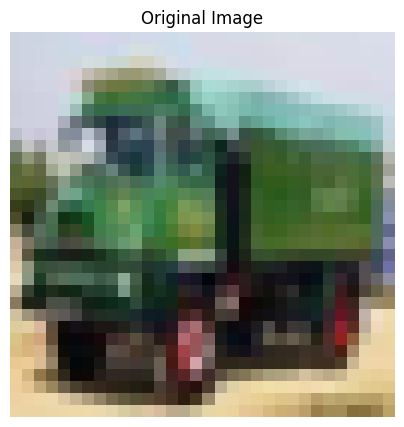

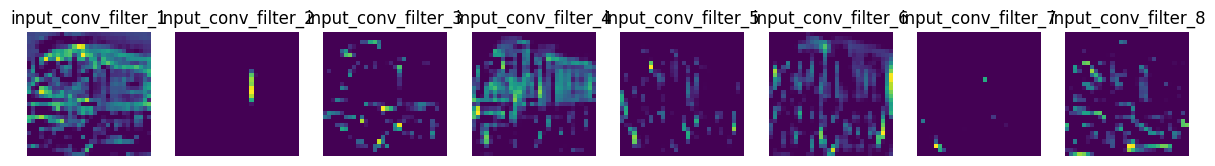

In [ ]:
# Create a Base Model - the simplier model using a Convolution layer
opt = Adam(learning_rate=0.0001) # Adam optimizer

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),name = 'input_conv'), # Input 2D Convolutional Layer
                    MaxPooling2D((2, 2)), # Max Pooling Layer to reduce the dimension
                    Flatten(), # Flatten Layer to get the data ready for the final Dense Layer
                    Dense(10, activation='softmax')]) # Dense Layer for classification Predictions

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time: ',end_time - start_time)
visualize_intermediate_outputs(model, ['input_conv'], X_valid)

In [ ]:
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Extra Metrics on Validation Set:
	Accuracy: 0.5349
	Precision Weighted: 0.5367729819758174
	Recall Weighted: 0.5349
	F1-Score Weighted: 0.534182171579744


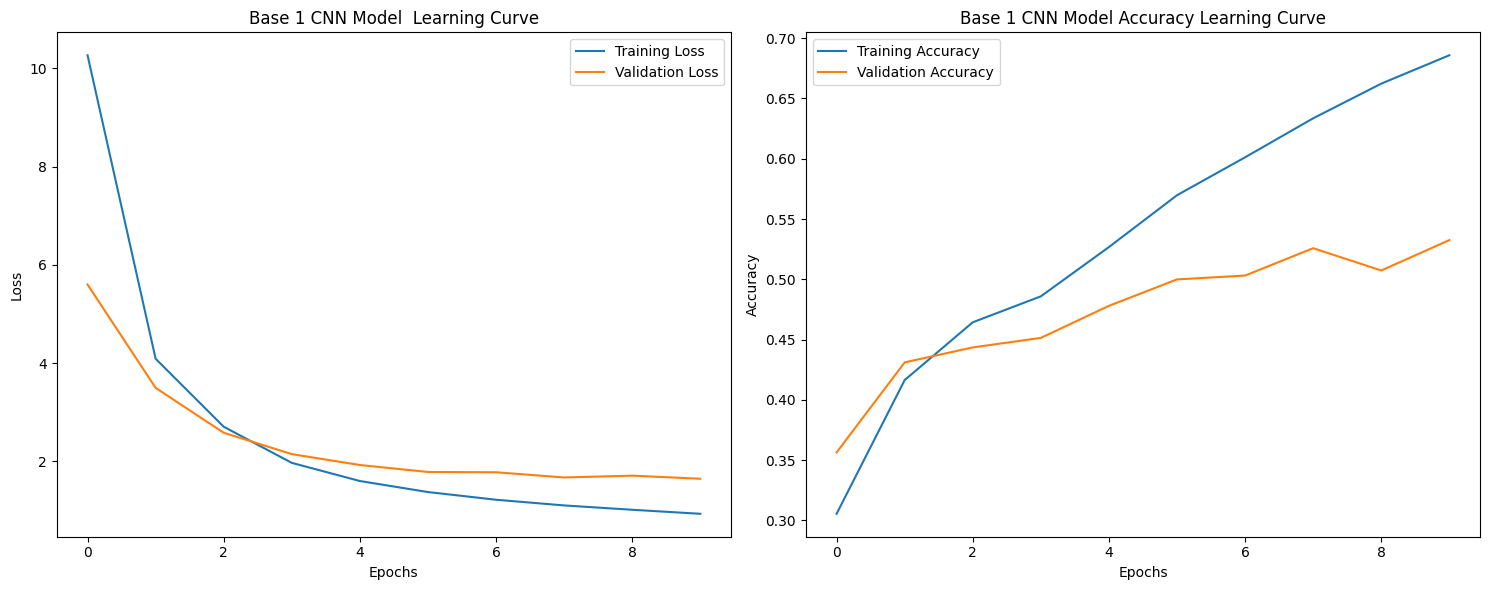

In [ ]:
model_plots(history,'Base 1 CNN Model')

In the previous cells, we saw that by using one convolutional layer we accomplished better accuracy than we did with more complex fully-connected Architectures with many more layers and much more investigation. The simple architecture already seems to be learning the complex patterns of the dataset images. The usage of Conv2D layers that exploit the spatial characteristics and features of the image seems very beneficial.

In the architecture below, a second Conv2D layer have been added.

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 2.3044 - accuracy: 0.3281 - val_loss: 1.5780 - val_accuracy: 0.4186
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4726 - accuracy: 0.4706 - val_loss: 1.4079 - val_accuracy: 0.5001
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3320 - accuracy: 0.5343 - val_loss: 1.3683 - val_accuracy: 0.5249
Epoch 4/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.2403 - accuracy: 0.5709 - val_loss: 1.3181 - val_accuracy: 0.5465
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1703 - accuracy: 0.5952 - val_loss: 1.2446 - val_accuracy: 0.5712
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1236 - accuracy: 0.6144 - val_loss: 1.2212 - val_accuracy: 0.5803
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0946 - accuracy: 0.6217 - val_loss: 1.1796 - val_accuracy:

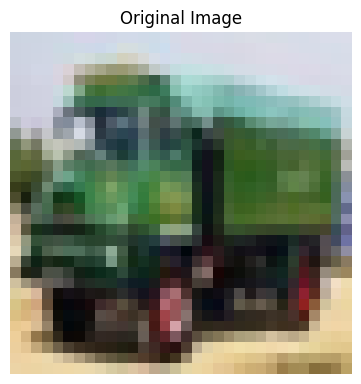

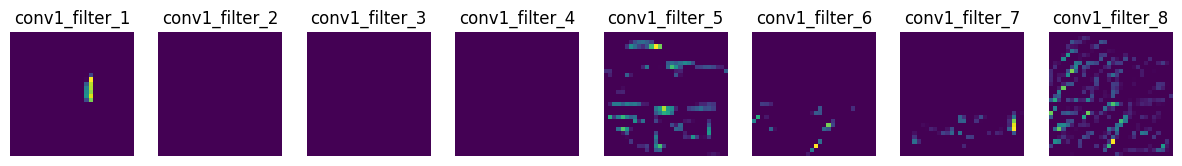

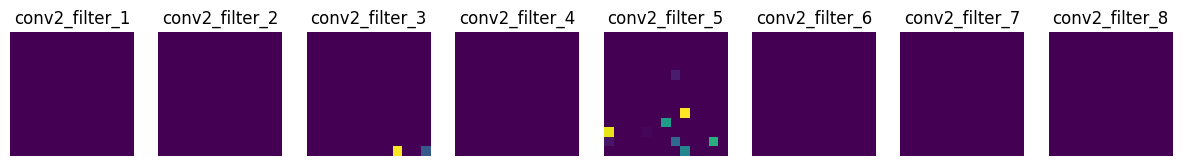

In [ ]:
model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu', name='conv2'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)
# Visualize intermediate outputs at certain epochs to check how the features are extracted
visualize_intermediate_outputs(model, ['conv1', 'conv2'], X_valid)

In [ ]:
print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Extra Metrics on Validation Set:
	Accuracy: 0.5887
	Precision Weighted: 0.5965956236309656
	Recall Weighted: 0.5887
	F1-Score Weighted: 0.5875378859467076


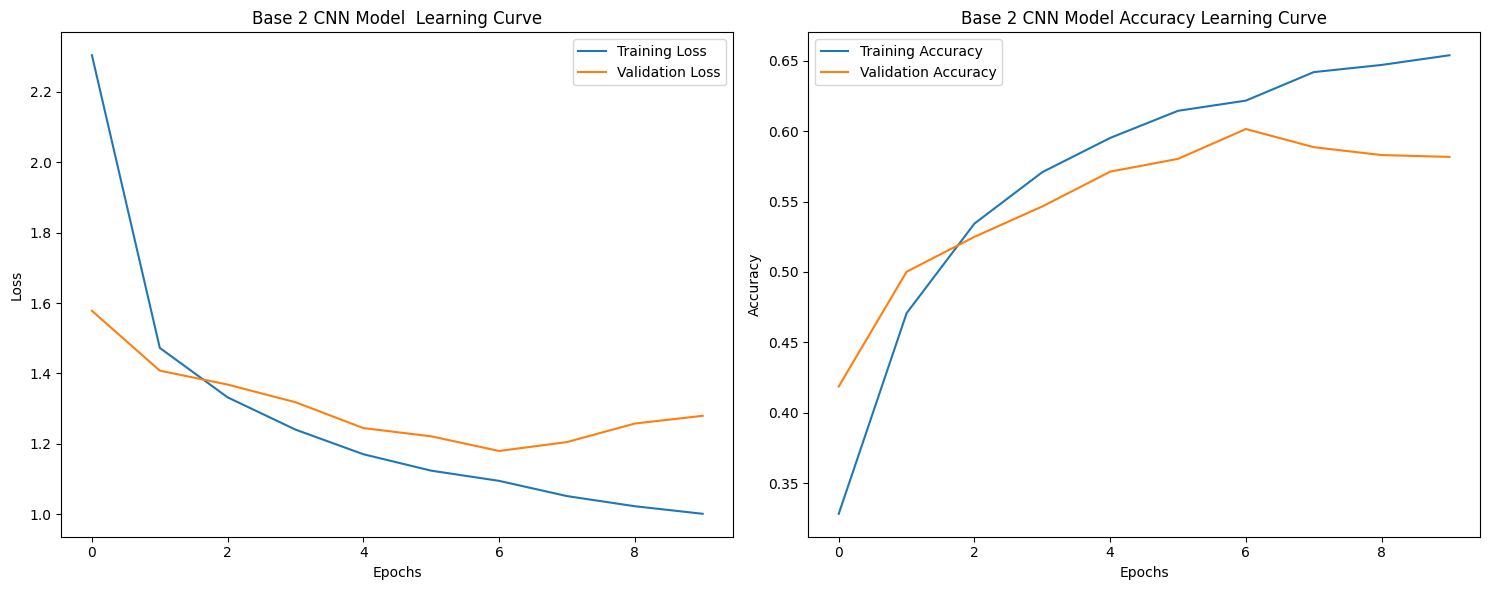

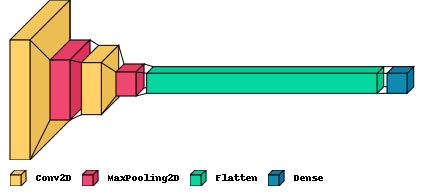

In [ ]:
model_plots(history,'Base 2 CNN Model')
visualkeras.layered_view(model,legend=True)

In [ ]:
model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((4, 4)),
                    Conv2D(64, (3, 3), activation='relu', name='conv2'),
                    MaxPooling2D((4, 4)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 8s 5ms/step - loss: 2.7982 - accuracy: 0.2782 - val_loss: 1.8319 - val_accuracy: 0.3541
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7289 - accuracy: 0.3853 - val_loss: 1.6727 - val_accuracy: 0.4096
Epoch 3/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.5952 - accuracy: 0.4336 - val_loss: 1.6262 - val_accuracy: 0.4336
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5010 - accuracy: 0.4672 - val_loss: 1.5227 - val_accuracy: 0.4637
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4319 - accuracy: 0.4943 - val_loss: 1.4813 - val_accuracy: 0.4926
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3702 - accuracy: 0.5219 - val_loss: 1.5313 - val_accuracy: 0.4531
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3203 - accuracy: 0.5373 - val_loss: 1.3360 - val_accuracy:

In [ ]:
model = Sequential([Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), activation='relu', name='conv2'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 13s 8ms/step - loss: 2.5859 - accuracy: 0.2016 - val_loss: 1.7893 - val_accuracy: 0.3510
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6237 - accuracy: 0.4130 - val_loss: 1.6382 - val_accuracy: 0.4305
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3915 - accuracy: 0.5117 - val_loss: 1.3627 - val_accuracy: 0.5126
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2415 - accuracy: 0.5672 - val_loss: 1.2612 - val_accuracy: 0.5720
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1576 - accuracy: 0.6015 - val_loss: 1.2011 - val_accuracy: 0.5948
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1013 - accuracy: 0.6230 - val_loss: 1.2529 - val_accuracy: 0.5860
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0507 - accuracy: 0.6409 - val_loss: 1.2318 - val_accurac

In [ ]:
model = Sequential([Conv2D(128, (3, 3), activation='sigmoid', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), activation='sigmoid', name='conv2'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6842 - accuracy: 0.3905 - val_loss: 1.4220 - val_accuracy: 0.4871
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3631 - accuracy: 0.5159 - val_loss: 1.3510 - val_accuracy: 0.5202
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.2490 - accuracy: 0.5569 - val_loss: 1.2402 - val_accuracy: 0.5624
Epoch 4/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1723 - accuracy: 0.5863 - val_loss: 1.1583 - val_accuracy: 0.5941
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1386 - accuracy: 0.6003 - val_loss: 1.2446 - val_accuracy: 0.5729
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1078 - accuracy: 0.6130 - val_loss: 1.1544 - val_accuracy: 0.5958
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0857 - accuracy: 0.6193 - val_loss: 1.1382 - val_accuracy:

In [ ]:
model = Sequential([Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu', name='conv2'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/20
1250/1250 [==============================] - 11s 6ms/step - loss: 2.1947 - accuracy: 0.3138 - val_loss: 1.6393 - val_accuracy: 0.4122
Epoch 2/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.4910 - accuracy: 0.4694 - val_loss: 1.4002 - val_accuracy: 0.5018
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3309 - accuracy: 0.5316 - val_loss: 1.2729 - val_accuracy: 0.5543
Epoch 4/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.2229 - accuracy: 0.5732 - val_loss: 1.2454 - val_accuracy: 0.5707
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1563 - accuracy: 0.6000 - val_loss: 1.2397 - val_accuracy: 0.5693
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1136 - accuracy: 0.6172 - val_loss: 1.2413 - val_accuracy: 0.5848
Epoch 7/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0633 - accuracy: 0.6345 - val_loss: 1.1755 - val_accuracy

In [ ]:
model = Sequential([Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    Conv2D(64, (3, 3), activation='relu', name='conv2'),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 2.9186 - accuracy: 0.1923 - val_loss: 2.0929 - val_accuracy: 0.2171
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 2.0198 - accuracy: 0.2573 - val_loss: 2.0091 - val_accuracy: 0.2494
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6716 - accuracy: 0.4045 - val_loss: 1.5755 - val_accuracy: 0.4490
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.2958 - accuracy: 0.5541 - val_loss: 1.4908 - val_accuracy: 0.5011
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9940 - accuracy: 0.6545 - val_loss: 1.6804 - val_accuracy: 0.4784
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7491 - accuracy: 0.7447 - val_loss: 1.9430 - val_accuracy: 0.4748
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5624 - accuracy: 0.8086 - val_loss: 2.3376 - val_accuracy:

In [ ]:
model = Sequential([Conv2D(64, (5, 5), activation='relu', input_shape=(32, 32, 3), name='conv1'),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (5, 5), activation='relu', name='conv2'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(10, activation='softmax')])

# Compile the model (you can use your preferred optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),use_multiprocessing =True)
end_time = time.time()

print(model.summary())
print('Training Time:', end_time - start_time)

print('Extra Metrics on Validation Set:')
predictions = model.predict(X_test,verbose=0)
metrics = evaluate_classification_metrics(y_test,predictions,verbose=True)

Epoch 1/10
1250/1250 [==============================] - 10s 7ms/step - loss: 2.6259 - accuracy: 0.0999 - val_loss: 2.3023 - val_accuracy: 0.0986
Epoch 2/10
1250/1250 [==============================] - 6s 4ms/step - loss: 2.3023 - accuracy: 0.1008 - val_loss: 2.3025 - val_accuracy: 0.1026
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3048 - accuracy: 0.1017 - val_loss: 2.3035 - val_accuracy: 0.0961
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3019 - accuracy: 0.0985 - val_loss: 2.3031 - val_accuracy: 0.0953
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3013 - accuracy: 0.1015 - val_loss: 2.3053 - val_accuracy: 0.0949
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3021 - accuracy: 0.1003 - val_loss: 2.3024 - val_accuracy: 0.0951
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3049 - accuracy: 0.1013 - val_loss: 2.3058 - val_accuracy

We observe that with simple architectures and no hyper-parameter tuning, the created Neural Networks can learn many of the complex patterns of the data. This comes as a result of the ability of the Convolutional Neural Networks that are able to extract spatial features. At the same time, CNNs are translation-invariant, meaning they can recognize patterns regardless of their position in the input.

The model had almost 60% Accuracy on the validation set.

In the following cells, an extended Search of the Optimal Hyperparameters is been performed. Different number of layers, and different parameters in each layer are searched.

*Note: Due to the fact that the documentation of the Keras Tuners did not support adding the number of epochs to the hyperparameter search space, the addition of Early Stopping was imperative. Early Stopping is used in order to stop the training of the model when the validation accuracy started to decrease for some concecutive epochs meaning that the model starts overfitting.*

In [ ]:
# Function that will be used in Hyper-parameter tuning to find the best model
def build_model(hp):
    model = Sequential()

    # Entry Convolutional Layer
    model.add(Conv2D(hp.Int('filters', min_value=32, max_value=256, step=32),
                     hp.Int('kernel_size', min_value=3, max_value=5),
                     padding='same', input_shape=(32, 32, 3), activation='relu'))

    # Convolutional Blocks
    for _ in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(Conv2D(hp.Int('filters', min_value=32, max_value=256, step=32),
                         hp.Int('kernel_size', min_value=3, max_value=5),
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(hp.Int('pool_size', min_value=2, max_value=3), hp.Int('pool_size', min_value=2, max_value=3))))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5)))

    # Flatten before Dense Layers
    model.add(Flatten())

    # Dense Layers
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5)))

    # Output Layer
    model.add(Dense(10, activation='softmax'))

    # Compiling the Created Model
    optimizer = Adam(learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

    return model

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    directory='random_tuner_results',
    project_name='cnn_tuning',
    overwrite = True
)

# Perform the hyperparameter search
tuner.search(X_train, y_train,epochs = 30,validation_data=(X_valid, y_valid),callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)])
# should also perform tuning on epochs

# Check the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters:", best_hp)

# Build the model with the best hyperparameters
best_model_random_search = tuner.get_best_models(num_models=1)[0]
print(best_model_random_search.summary())

Trial 5 Complete [00h 01m 22s]
val_accuracy: 0.10520000010728836

Best val_accuracy So Far: 0.7702999711036682
Total elapsed time: 00h 38m 56s
Best Hyperparameters: {'filters': 256, 'kernel_size': 5, 'num_layers': 3, 'pool_size': 3, 'dropout_rate': 0.2507959277388306, 'dense_units': 256, 'learning_rate': 0.00036972395759183116}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       19456     
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       1638656   
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 256)       0

 dropout_1 (Dropout)         (None, 3, 3, 256)         0         


 conv2d_3 (Conv2D)           (None, 3, 3, 256)         1638656   


 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 256)         0         


 g2D)                                                            


 dropout_2 (Dropout)         (None, 1, 1, 256)         0         


 flatten (Flatten)           (None, 256)               0         


 dense (Dense)               (None, 256)               65792     


 dropout_3 (Dropout)         (None, 256)               0         


 dense_1 (Dense)             (None, 10)                2570      


Total params: 5003786 (19.09 MB)


Trainable params: 5003786 (19.09 MB)


Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
best_model_random_search.save("best_random_search_model.keras")

In [ ]:
best_random_search_model = keras.models.load_model("best_random_search_model.keras")

In [ ]:
# Instantiate the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    num_initial_points=5,  # Number of randomly sampled hyperparameter combinations
    directory='bayesian_tuner_results',
    project_name='cnn_tuning',
    overwrite = True
)

# Perform the hyperparameter search
tuner.search(X_train, y_train,epochs = 30,validation_data=(X_valid, y_valid),callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)],use_multiprocessing =True)

# Check the Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters:", best_hp)

# Build the model with the best hyperparameters
best_model_bayesian_optimization = tuner.get_best_models(num_models=1)[0]
print(best_model_bayesian_optimization.summary())

In [ ]:
# Instantiate the tuner
tuner = GridSearch(
    build_model,
    max_trials=50,
    objective='val_accuracy',
    directory='grid_tuner_results',
    project_name='cnn_tuning',
    overwrite=True
)

# Perform the hyperparameter search
# Here I wanted to make sure that the number of epochs is sufficient for my model to learn
# but also will not lead to overfitting so I used Early Stopping
tuner.search(X_train, y_train,epochs = 10,validation_data=(X_valid, y_valid),callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)],use_multiprocessing =True)

# Check the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0].values
print("Best Hyperparameters:", best_hp)

# Build the model with the best hyperparameters
best_model_grid_search = tuner.get_best_models(num_models=1)[0]
print(best_model_grid_search.summary())

Trial 2 Complete [00h 17m 02s]
val_accuracy: 0.10239999741315842

Best val_accuracy So Far: 0.5004000067710876
Total elapsed time: 00h 39m 27s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
3                 |3                 |kernel_size
1                 |1                 |num_layers
2                 |2                 |pool_size
0                 |0                 |dropout_rate
128               |128               |dense_units
0.0001122         |1e-05             |learning_rate

Epoch 1/10
 277/1250 [=====>........................] - ETA: 1:31 - loss: 6.8847 - accuracy: 0.2336

In [ ]:
# Get the optimal model based on the ouput of the 3 different explorations
# Get the final best model
[val_loss,val_accuracy_random] = best_model_random_search.evaluate(X_valid, y_valid)
[val_loss,val_accuracy_bayesian] = best_model_bayesian_optimization.evaluate(X_valid, y_valid)
[val_loss,val_accuracy_grid] = best_model_grid_search.evaluate(X_valid, y_valid)

# Compare validation accuracies
best_accuracy = max(val_accuracy_random, val_accuracy_bayesian, val_accuracy_grid)

# Select the model with the best accuracy
best_model = None
if best_accuracy == val_accuracy_random:
    best_model = best_model_random_search
elif best_accuracy == val_accuracy_bayesian:
    best_model = best_model_bayesian_optimization
elif best_accuracy == val_accuracy_grid:
    best_model = best_model_grid_search

print("Best Validation Accuracy:", best_accuracy)
print("Best Model Summary:")
print(best_model.summary())

visualkeras.layered_view(best_model,legend=True)

Since the hyper-parameter tuning and the model fine tuning has been ended, the model performance on new unseen test data is implemented

In [ ]:
predictions = best_model.predict(X_test,verbose=0)

# Transform the labels to Label Encoding
y_pred = np.argmax(predictions,axis=1)
y_test = np.argmax(y_test,axis=1)
evaluate_classification_metrics(y_test, y_pred,verbose=True)

In [ ]:
# Visualize the outputs in the validation set, checking some examples of right and wrong classification

fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_test[i]], labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)